In [1]:
import models.vae as vae
import torch

encoded_space_dim = 4
fc2_input_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = vae.ConvVAE(encoded_space_dim=encoded_space_dim, fc2_input_dim=fc2_input_dim)
vae.to(device)

ConvVAE(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin_mean): Linear(in_features=288, out_features=4, bias=True)
  (encoder_lin_logvar): Linear(in_features=288, out_features=4, bias=True)
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNo

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)

train_X = trainset.data.type(torch.FloatTensor) / 255.0
train_X = train_X.to(device)
train_y = trainset.targets.type(torch.FloatTensor).to(device)

test_X = testset.data.type(torch.FloatTensor) / 255.0
test_X = test_X.to(device)
test_y = testset.targets.type(torch.FloatTensor).to(device)

train_loader = DataLoader(list(zip(train_X, train_y)), shuffle=True, batch_size=32)
test_loader = DataLoader(list(zip(test_X, test_y)), shuffle=True, batch_size=32)

In [4]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-05)

save_path = 'training_weights/' 
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.unsqueeze(1)
        data.to(device)

        reconstruct, mu, logvar = vae(data)
        loss = vae.loss_function(reconstruct, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader.dataset):.4f}')
    
torch.save(vae.state_dict(), save_path + 'vae_model.pth')

Epoch 1/10, Loss: 128.1474
Epoch 2/10, Loss: 127.8648
Epoch 3/10, Loss: 127.6018
Epoch 4/10, Loss: 127.4425
Epoch 5/10, Loss: 127.1636
Epoch 6/10, Loss: 127.0401
Epoch 7/10, Loss: 126.8677
Epoch 8/10, Loss: 126.7178
Epoch 9/10, Loss: 126.5447
Epoch 10/10, Loss: 126.4204


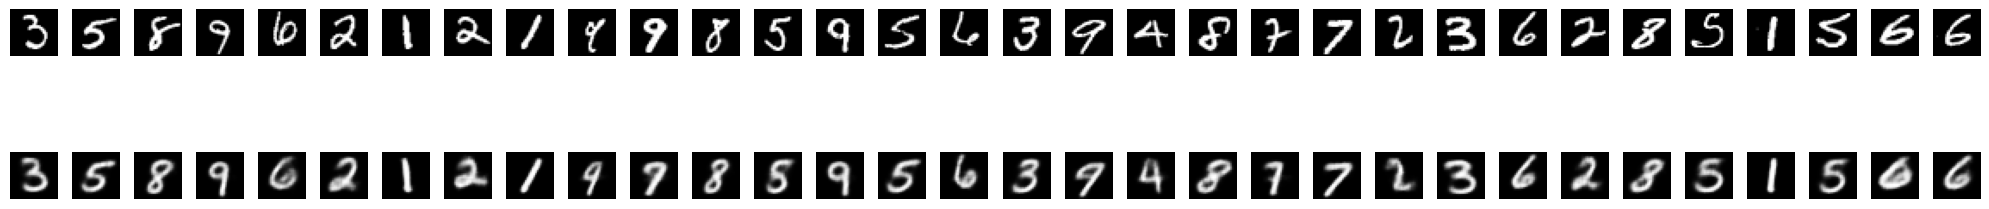

In [5]:
import matplotlib.pyplot as plt

vae.eval()

data, _ = next(iter(test_loader))
data = data.unsqueeze(1)
data = data.to(device)

with torch.no_grad():
    reconstruct, _, _ = vae(data)

reconstruct = reconstruct.cpu().numpy()
data = data.cpu().numpy()


fig, axes = plt.subplots(nrows=2, ncols=len(data), figsize=(20, 4))

for idx in range(len(data)):
    axes[0, idx].imshow(data[idx].squeeze(), cmap='gray')
    axes[0, idx].axis('off')

    axes[1, idx].imshow(reconstruct[idx].squeeze(), cmap='gray')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()
